In [1]:
# -----------------------------
# Step 0: Install dependencies if missing
# -----------------------------
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# pandas
try:
    import pandas as pd
except ImportError:
    install("pandas")
    import pandas as pd

# scikit-learn
try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
except ImportError:
    install("scikit-learn")
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# imbalanced-learn for SMOTE
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    install("imbalanced-learn")
    from imblearn.over_sampling import SMOTE

# xgboost
try:
    import xgboost as xgb
except ImportError:
    install("xgboost")
    import xgboost as xgb

import matplotlib.pyplot as plt

In [2]:
# Step 1: Load dataset
# -----------------------------
df = pd.read_csv("Uber_Customer_Support_Tickets_Prepared.csv")
print("Dataset loaded! Shape:", df.shape)
df.head()

Dataset loaded! Shape: (999, 15)


,Ticket_ID,Created_At,Channel,Response_Time_Minutes,Resolution_Time_Minutes,CSAT_Score,Issue_Type,Day,Month,Weekday,Daily_Ticket_Count,Channel_Code,Issue_Code,Resolution_Category,CSAT_Binary
0,T0001,21-02-2025,Live Agent,4,175,3,Ride Cancellation,21,2,Friday,13,1,5,Slow,0
1,T0002,15-01-2025,Live Agent,7,15,4,Lost Item,15,1,Wednesday,11,1,3,Fast,1
2,T0003,13-03-2025,Live Agent,8,162,4,Account Access,13,3,Thursday,9,1,0,Slow,1
3,T0004,02-03-2025,Live Agent,17,154,2,Lost Item,2,3,Sunday,12,1,3,Slow,0
4,T0005,21-01-2025,Chatbot,5,70,5,Lost Item,21,1,Tuesday,11,0,3,Slow,1


In [3]:
# -----------------------------
# Step 2: Feature engineering
# -----------------------------
# Create binary CSAT target
df['CSAT_High'] = (df['CSAT_Score'] >= 4).astype(int)

In [4]:
# Include anomaly flag if it exists
if 'Anomaly_Flag' not in df.columns:
    from sklearn.ensemble import IsolationForest
    iso = IsolationForest(contamination=0.05, random_state=42)
    df['Anomaly_Flag'] = iso.fit_predict(df[['Response_Time_Minutes','Resolution_Time_Minutes']])
    df['Anomaly_Flag'] = df['Anomaly_Flag'].map({1:0, -1:1})

In [5]:
# Features
features = ['Channel', 'Response_Time_Minutes', 'Resolution_Time_Minutes', 
            'Issue_Type', 'Daily_Ticket_Count', 'Anomaly_Flag']

X = pd.get_dummies(df[features], drop_first=True)
y = df['CSAT_High']

In [7]:
 
# Step 3: Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [8]:
# Step 4: Handle class imbalance (SMOTE)
# -----------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Resampled training set class distribution:")
print(pd.Series(y_train_res).value_counts())

Resampled training set class distribution:
CSAT_High
0    511
1    511
Name: count, dtype: int64


In [9]:
# Step 5: Train XGBoost classifier
# -----------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_res, y_train_res)

C:\Users\akhil\miniconda3\envs\openmm-env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [10]:
# Step 6: Evaluate model
# -----------------------------
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:,1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_score:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.38      0.39      0.39        72
           1       0.65      0.65      0.65       128

    accuracy                           0.56       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.56      0.56      0.56       200

Confusion Matrix:

[[28 44]
 [45 83]]
ROC-AUC Score: 0.5091


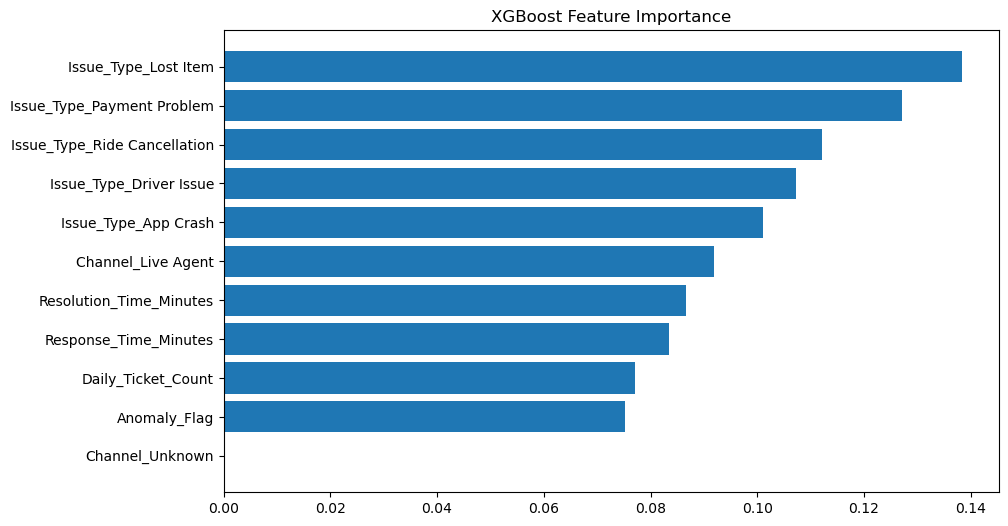

In [11]:
# Step 7: Feature Importance
# -----------------------------
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importances.index, feat_importances.values)
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()